# Loose ends in cancer genome structure

This notebook reproduces the figures from our paper.

# Dependencies

In [4]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(gGnome)
        library(gTrack)
        library(ggplot2)
        library(ggpubr)
    })
})

# Helper functions

In [3]:
dflm = function(x, last = FALSE, nm = '')
{
  if (is.null(x))
    out = data.frame(name = nm, method = as.character(NA), p = as.numeric(NA), estimate = as.numeric(NA), ci.lower = as.numeric(NA),  ci.upper = as.numeric(NA), effect = as.character(NA))
  else if (any(c('lm', 'betareg') %in% class(x)))
  {

    coef = as.data.frame(summary(x)$coefficients)
    colnames(coef) = c('estimate', 'se', 'stat', 'p')
    if (last)
      coef = coef[nrow(coef), ]
    coef$ci.lower = coef$estimate - 1.96*coef$se
    coef$ci.upper = coef$estimate + 1.96*coef$se
    if (!is.null(summary(x)$family))
    {
      fam = summary(x)$family$family
        if (summary(x)$family$link %in% c('log', 'logit'))
        {
          coef$estimate = exp(coef$estimate)
          coef$ci.upper= exp(coef$ci.upper)
          coef$ci.lower= exp(coef$ci.lower)
        }
    }
    else
      fam = 'Unknown'

    if (!last)
      nm = paste(nm, rownames(coef))
    out = data.frame(name = nm, method = fam, p = signif(coef$p, 3), estimate = coef$estimate, ci.lower = coef$ci.lower, ci.upper = coef$ci.upper, effect = paste(signif(coef$estimate, 3), ' [',  signif(coef$ci.lower,3),'-', signif(coef$ci.upper, 3), ']', sep = ''))
  }
  else if (class(x) == 'htest')
  {
    if (is.null(x$estimate))
      x$estimate = x$statistic
    if (is.null(x$conf.int))
      x$conf.int = c(NA, NA)
    out = data.table(name = nm, method = x$method, estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''), p = x$p.value)
  }
  else if (class(x) == 'polr')
  {
    coef = coef(summary(x)) %>% as.data.frame
    nm = paste(nm, rownames(coef))
    coef = as.data.table(coef)
    setnames(coef, c('estimate', 'se', 't'))
    out = data.table(name = nm) %>% cbind(coef)
    out$p =  pnorm(abs(out$t), lower.tail = FALSE) * 2
    out[, ci.lower := estimate-1.96*se]
    out[, ci.upper := estimate+1.96*se]
    out[, effect := paste(signif(estimate, 3), ' [',  signif(ci.lower,3),'-', signif(ci.upper, 3), ']', sep = '')]
  }
  else
  {
    out = data.frame(name = nm, method = x$method, p = signif(x$p.value, 3), estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''))
  }

  out$effect = as.character(out$effect)
  out$name = as.character(out$name)
  out$method = as.character(out$method)
  rownames(out) = NULL
  return(as.data.table(out))
}

# Figure 1
This figure gives an overview of benchmarking and a summary of junction and loose end counts in our pan-cancer cohort.

## Fig. 1b
Breakend call benchmarking in high-purity simulated genomes

In [5]:
mg.cncp.dt = readRDS("./data/benchmarking/cncp.rds")

precision.recall.cncp.dt = mg.cncp.dt[, .(median.precision = median(precision.cncp, na.rm = T),
                                          precision.lower = quantile(precision.cncp, na.rm = T, probs = 0.25),
                                          precision.upper = quantile(precision.cncp, na.rm = T, probs = 0.75),
                                          median.recall = median(recall.cncp, na.rm = T),
                                          recall.lower = quantile(recall.cncp, na.rm = T, probs = 0.25),
                                          recall.upper = quantile(recall.cncp, na.rm = T, probs = 0.75)),
                                      by = method]

precision.recall.cncp.dt[, method.level := ordered(method, c("JaBbA v1", 
                                                             "JaBbA v0", 
                                                             "ASCAT", 
                                                             "FACETS", 
                                                             "sequenza", 
                                                             "TITAN"))]

pt = ggplot(precision.recall.cncp.dt, aes(x = median.recall, y = median.precision)) +
    geom_point(size = 5, aes(color = method.level), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = method.level, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = method.level),
                  height = 0.01) +
    ylim(0, 1) +
    xlim(0, 1) +
    ggpubr::theme_pubr()

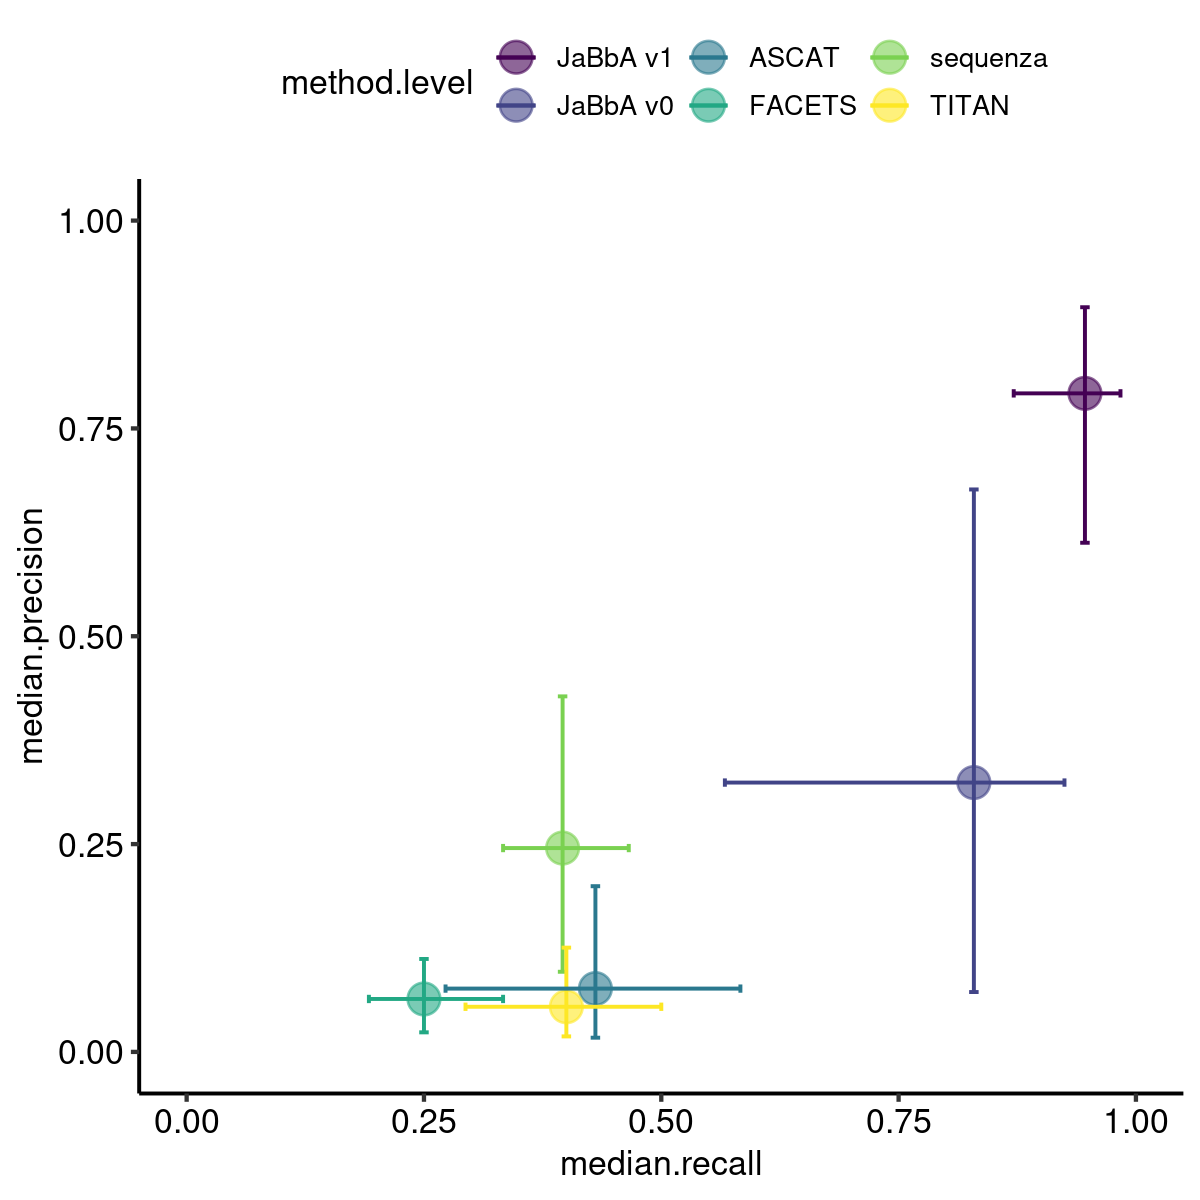

In [7]:
options(repr.plot.height = 6, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 1c
Correlation between loose end and junction breakend counts.

In [12]:
gg.pairs = readRDS("./data/sample.table.rds")

pt = ggplot(gg.pairs[(lambda_cohort) & !is.na(final_njuncs) & !is.na(final_nsomatic), 
                     .(final_njuncs, final_nsomatic)], 
            aes(x = final_njuncs * 2, y = final_nsomatic)) +
    geom_point(alpha = 0.5, size = 1) +
    geom_smooth(method = "lm", formula = y ~ x, mapping = aes(x = final_njuncs * 2, y = final_nsomatic)) +
    labs(x = "number of junction breakends", y = "number of loose ends") +
    geom_abline(slope = 1, intercept = 0) +
    scale_x_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    ggpubr::stat_cor(method = "pearson", label.x = 0.5, label.y = 5)

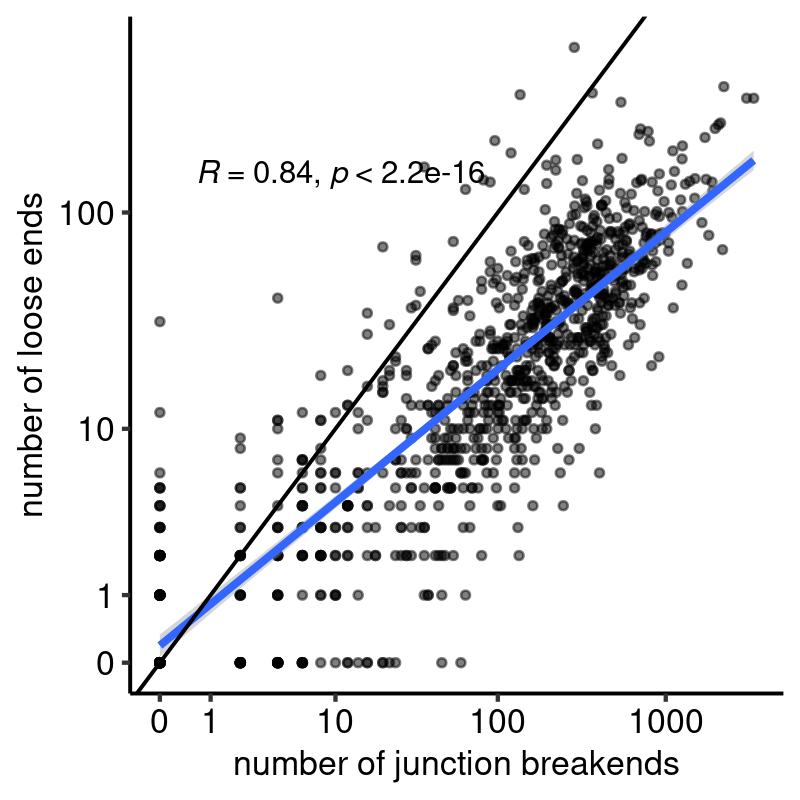

In [14]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 1d
Junction counts versus loose end counts arranged by tumor type.

In [15]:
gg.pairs = readRDS("./data/sample.table.rds")

pt.dt = rbind(gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_njuncs * 2, type = "junction")],
              gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_nsomatic, type = "loose")])

pt.dt = pt.dt[!is.na(tumor_type_final)]

pt.dt[, sample := ordered(pair, levels = pt.dt[type == "junction"][order(count), pair])]
pt.dt[, label := ordered(tumor_type_final, levels = pt.dt[type == "junction"][, .(count = median(count)), by = tumor_type_final][order(count), tumor_type_final])]

pt = ggplot(pt.dt, aes(x = sample, y = count)) +
    facet_grid(rows = vars(type), cols = vars(label)) +
    geom_point(size = 0.01) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank()) +
    theme(strip.text.x = element_text(angle = 90))

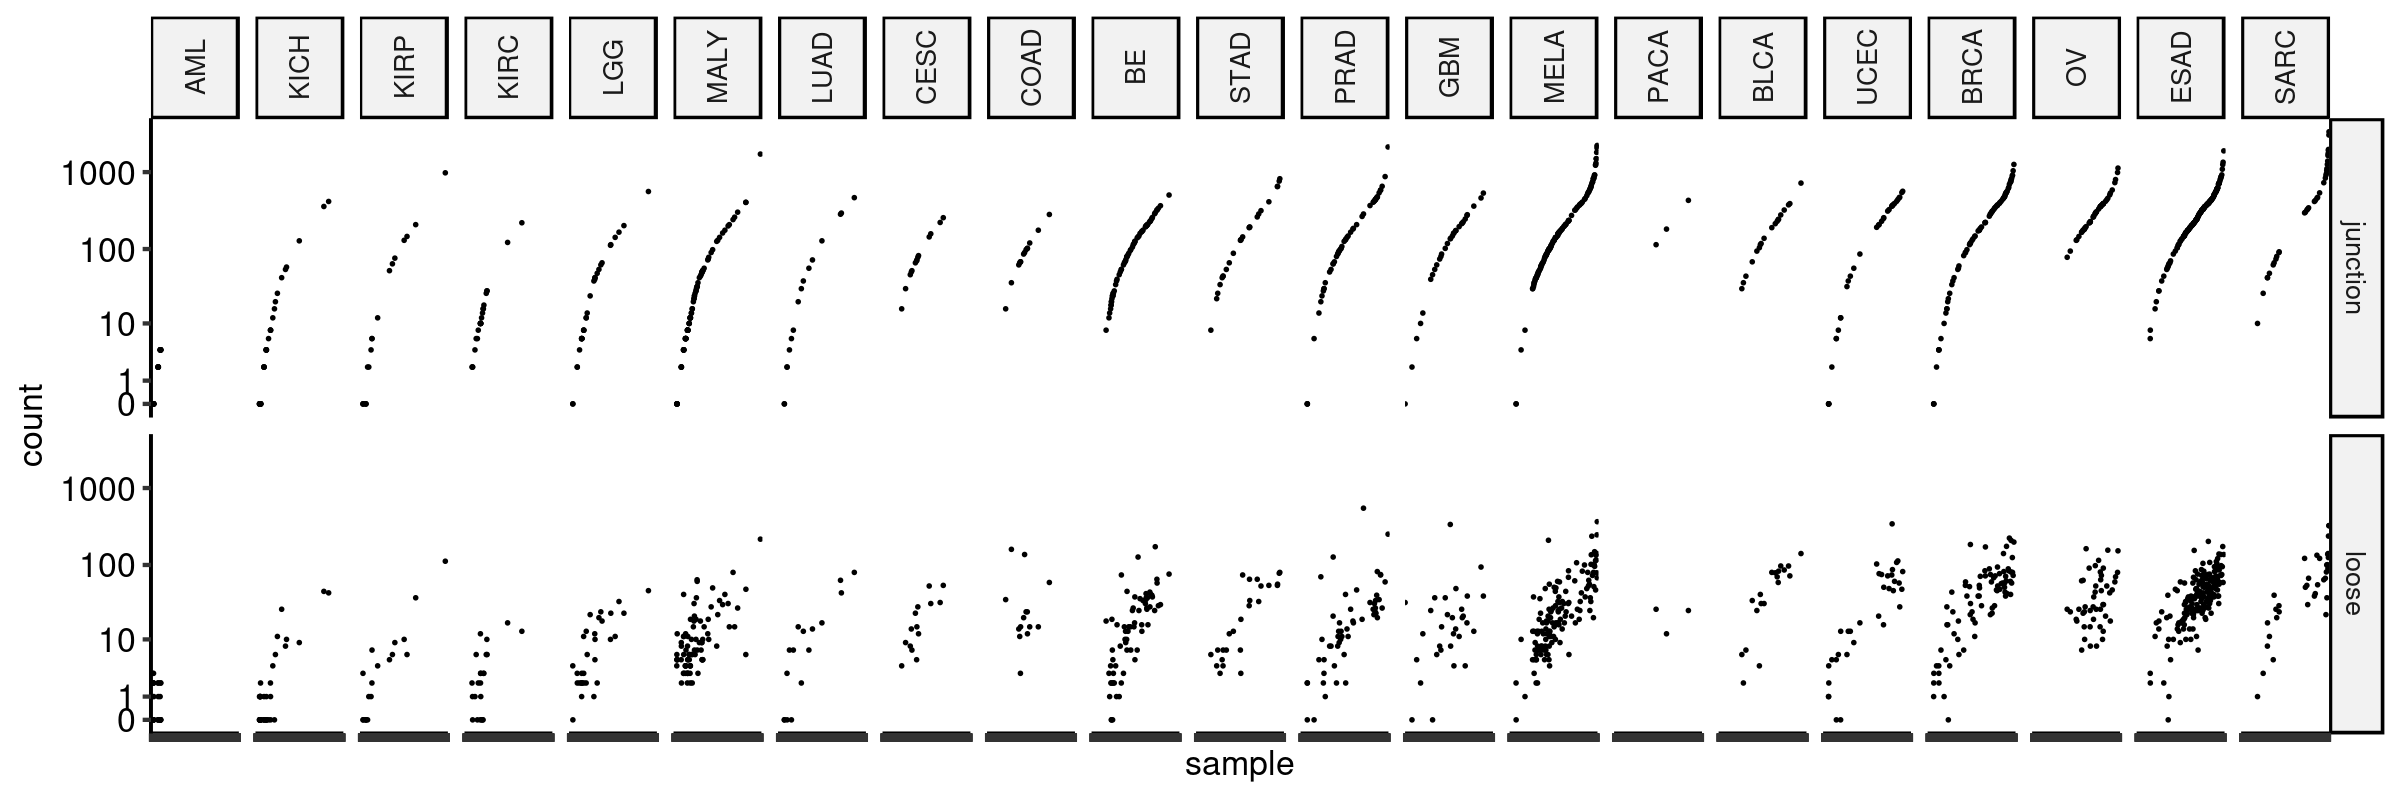

In [17]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
pt

## Fig. 1e
Proportion of breakends corresponding to junctions versus loose ends, and whether they are associated with SCNAs or copy neutral